In [32]:
# --- Imports and environment check ---
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

print("Python:", os.sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Python: 3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]
TensorFlow: 2.16.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
# --- Paths and configuration ---
DATA_DIR = "../data_small_preprocessed/train"  # single folder with class subfolders
TEST_DIR = "../data_small_preprocessed/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
CLASS_MODE = 'categorical'
COLOR_MODE = 'grayscale'

In [34]:
# --- ImageDataGenerators ---
# Rescale only, no CLAHE, no over-augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=8,
    width_shift_range=0.03,
    height_shift_range=0.03,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# --- Generators ---
train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    subset='training',
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=SEED,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train samples:", train_gen.samples)
print("Val samples:", val_gen.samples)
print("Test samples:", test_gen.samples)
print("Classes:", train_gen.class_indices)

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 201 images belonging to 4 classes.
Train samples: 480
Val samples: 120
Test samples: 201
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Batch dtype: float32 | Range: (0.0, 1.0)


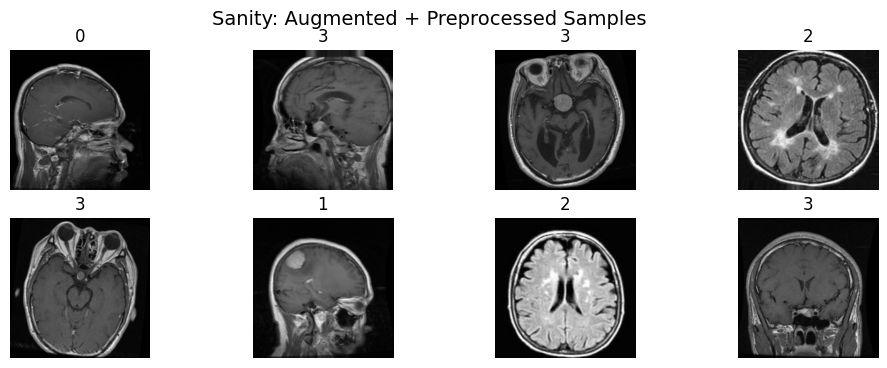

In [35]:
# --- Visual sanity check ---
x_batch, y_batch = next(train_gen)
print("Batch dtype:", x_batch.dtype, "| Range:", (x_batch.min(), x_batch.max()))

plt.figure(figsize=(12,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.suptitle("Sanity: Augmented + Preprocessed Samples", fontsize=14)
plt.show()

In [36]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(224,224,1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256),
    LeakyReLU(alpha=0.05),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(alpha=0.05),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             

 Total params: 13,268,484 (50.62 MB)

 Trainable params: 13,267,524 (50.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [37]:
# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=6, min_lr=1e-6, verbose=1),
    ModelCheckpoint('custom_cnn_best.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [38]:
# --- Train the model ---
BATCH_SIZE = 32  # update this before your generators

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.4396 - loss: 4.3693 - val_accuracy: 0.2500 - val_loss: 1.4824 - learning_rate: 2.0000e-04
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5479 - loss: 2.0042 - val_accuracy: 0.2500 - val_loss: 1.4467 - learning_rate: 2.0000e-04
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5979 - loss: 1.2642 - val_accuracy: 0.2500 - val_loss: 1.9034 - learning_rate: 2.0000e-04
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6271 - loss: 1.0111 - val_accuracy: 0.2500 - val_loss: 1.8939 - learning_rate: 2.0000e-04
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.6417 - loss: 0.9106 - val_accuracy: 0.3500 - val_loss: 1.7710 - learning_rate: 2.0000e-04
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.6958 - loss: 0.8293 - val_accuracy: 0.5333 - val_loss: 1.6354 - learning_rate: 2.0000e-04
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 

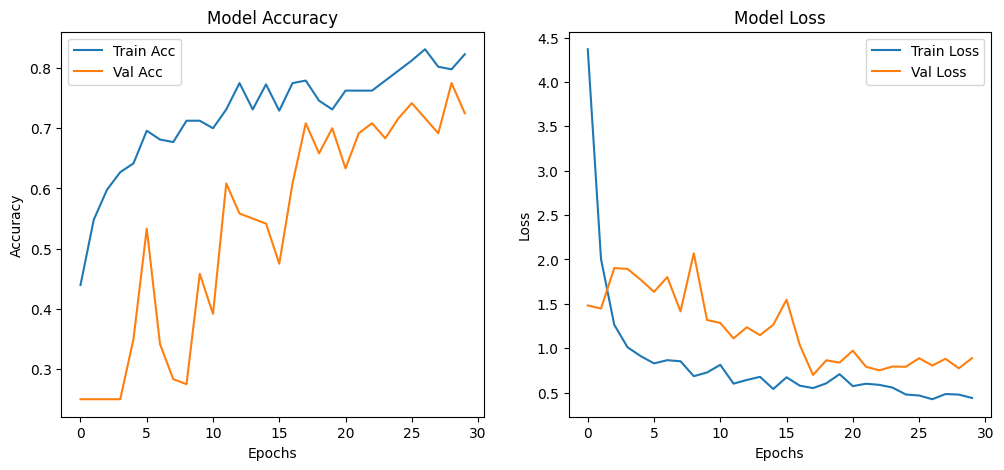

In [39]:
# --- Plot training curves ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [40]:
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"Best epoch: {best_epoch+1}")
print(f"Val Accuracy at best epoch: {history.history['val_accuracy'][best_epoch]:.4f}")

Best epoch: 29
Val Accuracy at best epoch: 0.7750


In [41]:
# ==== Evaluate Best Model on Test Set ====

from tensorflow.keras.models import load_model

# Load the best saved model (ensure path matches your checkpoint)
best_model = load_model('custom_cnn_best.keras')

# Evaluate on the test generator
test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)

print(f"Test Accuracy (best weights): {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7463 - loss: 0.7527
Test Accuracy (best weights): 0.7463
Test Loss: 0.7527


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_true = test_gen.classes
y_pred = np.argmax(best_model.predict(test_gen), axis=1)

# Print detailed metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

Confusion Matrix:
 [[38  9  1  3]
 [11 22 16  1]
 [ 4  2 44  0]
 [ 2  2  0 46]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6909    0.7451    0.7170        51
           1     0.6286    0.4400    0.5176        50
           2     0.7213    0.8800    0.7928        50
           3     0.9200    0.9200    0.9200        50

    accuracy                         0.7463       201
   macro avg     0.7402    0.7463    0.7369       201
weighted avg     0.7400    0.7463    0.7368       201



In [43]:
import shutil
shutil.copy("custom_cnn_best.keras", "custom_cnn_final_best_v1.keras")

'custom_cnn_final_best_v1.keras'